# Carga de librerías

In [1]:
import numpy as np
import os


import random
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import tensorflow as tf

# Loads an image into PIL format.
from tensorflow.keras.preprocessing import image

#Preprocesa un tensor o matriz Numpy codificando un lote de imágenes.
from tensorflow.keras.applications.imagenet_utils import preprocess_input

# Para codificaciones one-hot
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D

# Para cargar el modelo ResNet50V2
from tensorflow.keras.applications import ResNet50V2

# Carga de los datos

In [2]:
root = 'dataset'

for root, dirs, files in os.walk(root):
    if len(dirs) > 0:
        categories = [os.path.join(root, x) for x in dirs if x not in []]

In [3]:
categories

['dataset\\training_set\\cats', 'dataset\\training_set\\dogs']

In [4]:
def get_image(path):
    
    # Se carga la imagen y se hace un resize, ya que es el tamaño que requiere ResNetV2 (224x224 RGB)
    img = image.load_img(path, target_size=(224, 224))
    
    # Se transforma a un array
    x = image.img_to_array(img)
    
    # np.expand_dims expande la forma de una matriz
    # Inserta un nuevo eje que aparecerá en la posición
    # del parámetro axis en la forma de matriz expandida.
    
    # "axis" indica la posición en los ejes expandidos 
    # donde se coloca el nuevo eje (o ejes).
    
    # Tamaño inicial de la imagen: (224, 224, 3)
    # Tamaño expandido de la imagen: (1, 224, 224, 3)    
    x = np.expand_dims(x, axis=0)
    
    #Preprocesa un tensor o matriz Numpy codificando un lote de imágenes.
    # Devuelve un numpy.array o un tf.Tensor preprocesado con tipo float32.
    x = preprocess_input(x)
    
    return img, x

Ahora cargaremos los datos del directorio:

In [5]:
# Inicializamos una lista para almacenar diccionarios imagen-categoría
data = []

# Para cada índice, categoría:
for c, category in enumerate(categories):
    
    # Inicializamos lista para almacenar las imágenes de la categoría
    images = []
    
    # Para cada root, dir intermedio (vacío), filename en la categoría
    for dp, _, filenames in os.walk(category):
        
        # Para cada nombre de imagen 
        for f in filenames:
            
            # print(os.path.splitext(f)) # Devuelve ('image_0001', '.jpg')
            # Si la extensión del archivo está bien:
            if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']:
                images.append(os.path.join(dp, f))
                
    for img_path in images:
    
        # Utilizamos ahora la función de carga definida más arriba
        img, x = get_image(img_path)

        # Creamos un diccionario para generar cada X y su target
        data.append({'x':np.array(x[0]), 'y':c})
                

In [6]:
num_classes = len(categories)
num_classes

2

Mezclamos los datos para darles aleatoriedad:

In [7]:
random.shuffle(data)

Y se definen las particiones de entrenamiento (train) y validación (val):

In [8]:
# Particiones de train y validation
train_split, val_split = 0.85, 0.15 # Val split: 0.15

In [9]:
# Los datos de entrenamiento se tomarán desde el principio hasta idx_val
idx_val = int(train_split * len(data))
idx_val

6800

In [10]:
len(data)

8000

In [11]:
# Los datos de entrenamiento se toman desde el principio hasta idx_val
train = data[:idx_val]

In [12]:
len(train)

6800

In [13]:
# Los datos de validación se toman desde el idx_val hasta idx_test
val = data[idx_val:]

In [14]:
len(val)

1200

Separamos ahora los datos de las etiquetas:

In [15]:
X_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]

In [16]:
X_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]

# Preprocesamiento de los datos

Preprocesaremos los datos para asegurarnos de que sean float32 y estén normalizados entre -1 y 1.

In [17]:
# Normalización
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [18]:
X_train = rescale(X_train)
X_val = rescale(X_val)

In [19]:
# Conversión de etiquetas en vectores one-hot
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)

In [20]:
y_val

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

Un resumen de los valores obtenidos hasta ahora:

In [21]:
print('*'*100)
print('')
print(f"Se han cargado {len(data)} imágenes de {num_classes} categorías")
print(f"Entrenamiento {len(X_train)} / Validación {len(X_val)}")
print('-'*100)
print(f"Dimensiones de las variables del subconjunto de entrenamiento: {X_train.shape}")
print(f"Dimensiones de las etiquetas de entrenamiento: {y_train.shape}")
print('-'*100)
print(f"Dimensiones de las variables del subconjunto de validación: {X_val.shape}")
print(f"Dimensiones de las etiquetas de validación: {y_val.shape}")
print('')
print('*'*100)

****************************************************************************************************

Se han cargado 8000 imágenes de 2 categorías
Entrenamiento 6800 / Validación 1200
----------------------------------------------------------------------------------------------------
Dimensiones de las variables del subconjunto de entrenamiento: (6800, 224, 224, 3)
Dimensiones de las etiquetas de entrenamiento: (6800, 2)
----------------------------------------------------------------------------------------------------
Dimensiones de las variables del subconjunto de validación: (1200, 224, 224, 3)
Dimensiones de las etiquetas de validación: (1200, 2)

****************************************************************************************************


A continuación vamos a representar una muestra aleatoria de imágenes para comprobar con qué estamos trabajando:

In [22]:
# Tomamos una muestra aleatoria de imágenes, para lo cual seleccionamos su índice
idx = [int(len(images) * random.random()) for i in range(8)]
idx

[1310, 464, 2074, 2150, 650, 1361, 1426, 2020]

In [23]:
# Las cargamos con keras en formato PIL
imgs = [image.load_img(images[i], target_size=(224, 224)) for i in idx]
imgs

[<PIL.Image.Image image mode=RGB size=224x224 at 0x157E01AB320>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x157C915C0B8>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x157C915C160>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x157C915C358>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x157DB1D1DA0>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x157DB1D1E80>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x157DB1D1D30>,
 <PIL.Image.Image image mode=RGB size=224x224 at 0x157DB1D1B00>]

In [24]:
# Convertimos la lista anterior en una lista de arrays de numpy
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)

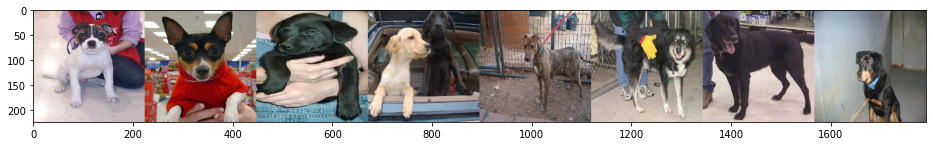

In [25]:
plt.figure(figsize=(16,4))
plt.imshow(concat_image)
plt.show()

# Transfer Learning

## Entrenando el Modelo ResNet50 V2 

Instanciamos el modelo ResNet50 V2:

In [26]:
ResNet = ResNet50V2(weights='imagenet', include_top=True)
ResNet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [27]:
# Hacemos referencia a la capa de entrada de ResNet
inp = ResNet.input

# Creamos una nueva capa softmax con tantas neuronas como num_classes
new_classification_layer = Dense(num_classes, activation='softmax')

# Conectamos nuestra nueva capa a la estructura copiada de ResNet50V2 
# (desde la segunda hasta la última capa de ResNet50V2), 
# y hacemos una referencia a ella
out = new_classification_layer(ResNet.layers[-2].output)

# Creamos una nueva red entre inp y out
model_new = Model(inp, out)

In [28]:
# Hacemos todas las capas "no entrenables" congelando sus pesos (excepto la última)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# Nos aseguramos de que la última capa sea entrenable (no esté congelada)
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
______________________________________________________________________________________________

Seguidamente, se lleva a cabo el entrenamiento del nuevo modelo con todas las capas y pesos congelados exceptuando la nueva última capa:

In [29]:
history_1 = model_new.fit(X_train, y_train, 
                         batch_size=32, 
                         epochs=10, 
                         validation_data=(X_val, y_val))

Epoch 1/10
213/213 [==============================] - 341s 2s/step - loss: 0.6108 - accuracy: 0.6784 - val_loss: 0.4768 - val_accuracy: 0.7467
Epoch 2/10
213/213 [==============================] - 290s 1s/step - loss: 0.4862 - accuracy: 0.7381 - val_loss: 0.5063 - val_accuracy: 0.7300
Epoch 3/10
213/213 [==============================] - 340s 2s/step - loss: 0.4658 - accuracy: 0.7557 - val_loss: 0.4869 - val_accuracy: 0.7308
Epoch 4/10
213/213 [==============================] - 353s 2s/step - loss: 0.4322 - accuracy: 0.7825 - val_loss: 0.4736 - val_accuracy: 0.7508
Epoch 5/10
213/213 [==============================] - 353s 2s/step - loss: 0.4412 - accuracy: 0.7721 - val_loss: 0.5089 - val_accuracy: 0.7300
Epoch 6/10
213/213 [==============================] - 349s 2s/step - loss: 0.4121 - accuracy: 0.7909 - val_loss: 0.4619 - val_accuracy: 0.7550
Epoch 7/10
213/213 [==============================] - 353s 2s/step - loss: 0.4264 - accuracy: 0.7829 - val_loss: 0.4836 - val_accuracy: 0.7458

A continuación, se representan los valores de la función de coste y precisión para los datos de validación:

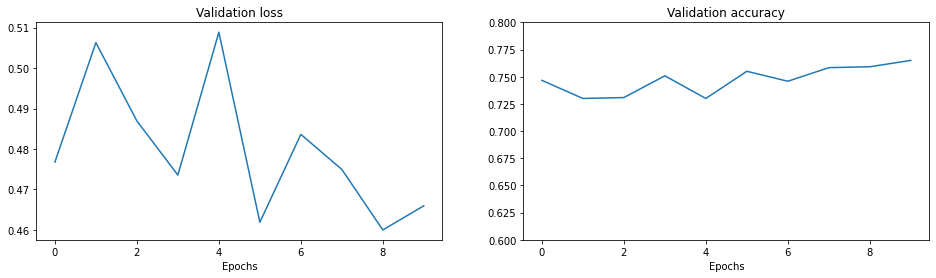

In [30]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history_1.history["val_loss"])
ax.set_title("Validation loss")
ax.set_xlabel("Epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history_1.history["val_accuracy"])
ax2.set_title("Validation accuracy")
ax2.set_xlabel("Epochs")
ax2.set_ylim(0.6, 0.8)

plt.show()

Atendiendo a las gráficas arriba mostradas, la pérdida de validación obtiene su mínimo valor en la octava epoch. Del mismo modo, para esa misma epoch se alcanza la mayor precisión del modelo. A partir de dicha epoch todo parece indicar que se reduce la precisión así como se aumenta la pérdida de validación, lo que se traduce en sobreajuste, aunque serían necesarias más epochs para terminar de determinar ese escenario con acierto.

En general, aplicando Transfer-Learning se obtiene una precisión alrededor del 80% para los datos de entrenamiento y del 75% para los de validación.

## Predicciones

Cargamos los datos de test:

In [31]:
root = 'test_set'

for root, dirs, files in os.walk(root):
    if len(dirs) > 0:
        categories_test = [os.path.join(root, x) for x in dirs if x not in []]

In [32]:
categories_test

['test_set\\cats', 'test_set\\dogs']

In [33]:
data_test = []

for c, category in enumerate(categories_test):
    
    images_test = []
    
    for dp, _, filenames in os.walk(category):
        
        for f in filenames:
            
            if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']:
                images_test.append(os.path.join(dp, f))
                
    for img_path_test in images_test:
    
        img, x = get_image(img_path_test)
        data_test.append({'x':np.array(x[0]), 'y':c})

Mezclamos los datos para darles aleatoriedad:

In [34]:
random.shuffle(data_test)

Y separamos de nuevo los datos de las etiquetas, al igual que hicimos con los datos de entrenamiento:

In [35]:
X_test, y_test = np.array([t["x"] for t in data_test]), [t["y"] for t in data_test]
print(y_test)

[1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 

Comprobamos que se han cargado correctamente las etiquetas de las 2000 imágenes del conjunto de test:

In [36]:
len(y_test)

2000

Normalizamos los datos y realizamos la conversión one-hot para las etiquetas:

In [37]:
X_test = rescale(X_test)
y_test = to_categorical(y_test, num_classes)
print(y_test.shape)

(2000, 2)


A modo de resumen:

In [38]:
print('*'*100)
print('')
print(f"Se han cargado {len(data_test)} imágenes de {num_classes} categorías")
print('-'*100)
print(f"Dimensiones de las variables del subconjunto de test: {X_test.shape}")
print(f"Dimensiones de las etiquetas de test: {y_test.shape}")
print('')
print('*'*100)

****************************************************************************************************

Se han cargado 2000 imágenes de 2 categorías
----------------------------------------------------------------------------------------------------
Dimensiones de las variables del subconjunto de test: (2000, 224, 224, 3)
Dimensiones de las etiquetas de test: (2000, 2)

****************************************************************************************************


Por último, realizaremos una valoración del modelo en base a sus predicciones:

In [39]:
loss, accuracy = model_new.evaluate(X_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.46962225437164307
Test accuracy: 0.7745000123977661


Obteniéndose unos valores similares a los conseguidos durante el entrenamiento.

Si se quisiera predecir una imagen:

In [40]:
img, x = get_image('test_set/cats/cat.4014.jpg')
pred = model_new.predict([x])

In [41]:
pred.max()

1.0

In [42]:
pred.argmax()

0

In [43]:
categories_test[0]

'test_set\\cats'

Para el caso particular de la imagen cat.4014.jpg, el modelo predice con una probabilidad de acierto del 100% que la figura se corresponde con la categoría de gato.